# Deep Q Learning with Atari© Space Invaders© 🕹️👾

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices
#import retro                 # Retro Environment
from PIL import Image
import gym
from datetime import datetime
from packaging import version
from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames

import matplotlib.pyplot as plt # Display graphs

from collections import deque# Ordered collection with ends

import random

# Load the TensorBoard notebook extension.
%load_ext tensorboard
import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore') 

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.0.0


In [2]:
env = gym.make('CartPole-v1')  #CartPole-v0,MsPacman-v0,Hopper-v3,MountainCar-v0
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

In [3]:
# Create our environment
#env = retro.make(game='SpaceInvaders-Atari2600')

print("The size of our frame is: ", env.observation_space)
print("The action size is : ", env.action_space.n)

# Here we create an hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0]...]
#possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())

The size of our frame is:  Box(4,)
The action size is :  2


In [7]:
set([env.action_space.sample() for i in range(100)])

{0, 1}

In [8]:
print(env.reward_range)

#print(env.observation_space.high)

#print(env.observation_space.low)

(-inf, inf)


In [9]:
state= env.reset()

In [10]:
state

array([-0.02733327, -0.02475361,  0.01364489, -0.04023929])

## Step 3 : Define the preprocessing functions ⚙️
### preprocess_frame
Preprocessing is an important step, <b>because we want to reduce the complexity of our states to reduce the computation time needed for training.</b>
<br><br>
Our steps:
- Grayscale each of our frames (because <b> color does not add important information </b>).
- Crop the screen (in our case we remove the part below the player because it does not add any useful information)
- We normalize pixel values
- Finally we resize the preprocessed frame

In [4]:
obs = env.reset()

In [4]:
obs.shape

(210, 160, 3)

In [3]:
"""
    preprocess_frame:
    Take a frame.
    Grayscale it
    Resize it.
        __________________
        |                 |
        |                 |
        |                 |
        |                 |
        |_________________|
        
        to
        _____________
        |            |
        |            |
        |            |
        |____________|
    Normalize it.
    
    return preprocessed_frame
    
    """

def preprocess_frame(frame,resize_shape):
    frame = Image.fromarray(frame)
    w,h= frame.size
    upper_y,lower_y,left_x,right_x=.1*h,.88*h,.05*w,.8*w
    left=left_x; upper = upper_y; right = right_x; lower= lower_y
    frame_cropped=frame.crop(box=(left,upper,right,lower))
    frame_cropped = frame_cropped.resize(resize_shape)
    frame_cropped=np.array(frame_cropped)
    frame_cropped=frame_cropped/255.
    grey = rgb2gray(frame_cropped)
    return(grey)
    

In [4]:
processed_obs = preprocess_frame(obs,((state_size[1],state_size[0])))

NameError: name 'obs' is not defined

In [135]:
processed_obs.shape

(110, 84)

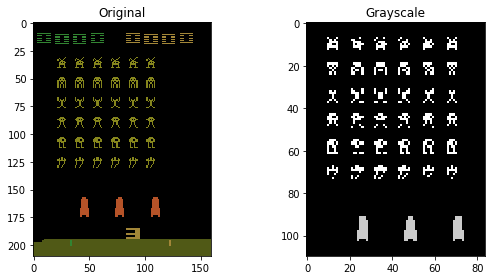

In [136]:


original = obs
grayscale = rgb2gray(obs)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(processed_obs, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()


### stack_frames
As explained in this really <a href="https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/">  good article </a> we stack frames.

Stacking frames is really important because it helps us to **give have a sense of motion to our Neural Network.**

BUT, **we don't stack each frames, we skip 4 frames at each timestep**. This means that only every fourth frame is considered. And then, we use this frame to form the stack_frame.

**The frame skipping method is already implemented in the library.**

- First we preprocess frame
- Then we append the frame to the deque that automatically **removes the oldest frame**
- Finally we **build the stacked state**

This is how work stack:
- For the first frame, we feed 4 frames
- At each timestep, **we add the new frame to deque and then we stack them to form a new stacked frame**
- And so on
<img src="https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/assets/stack_frames.png" />
- If we're done, **we create a new stack with 4 new frames (because we are in a new episode)**.

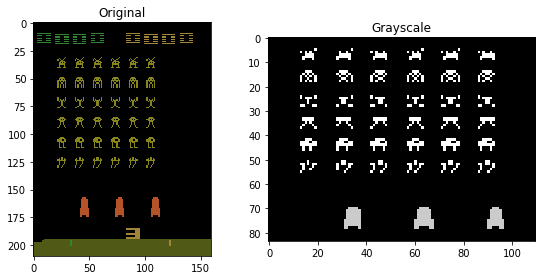

In [137]:


original = obs
grayscale = rgb2gray(obs)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(obs1)
ax[0].set_title("Original")
ax[1].imshow(xyz[-1], cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()


In [122]:
xyz[-1].shape

(84, 110)

In [124]:
state_size

[110, 84, 4]

In [8]:
def stack_frames(frame,stack_frame_deque,initial=False):
    global state_size
    resize_shape = (state_size[1],state_size[0])
    frame = preprocess_frame(frame,resize_shape)
    if initial:
        [stack_frame_deque.append(frame) for i in range(state_size[2])]
    else:
        stack_frame_deque.append(frame)
    stacked_frame = np.stack(stack_frame_deque,axis=2)
    return(stacked_frame,stack_frame_deque)

In [6]:
stack_frame_deque = deque(maxlen=state_size[2])

NameError: name 'state_size' is not defined

In [127]:
stacked_frame,stack_frame_deque = stack_frames(obs,stack_frame_deque,initial=True)

In [128]:
stacked_frame.shape

(110, 84, 4)

In [129]:
obs.max(),stacked_frame.max()

(181, 0.49580196078431377)

In [130]:
obs1 = env.reset()

In [131]:
stacked_frame,stack_frame_deque = stack_frames(obs1,stack_frame_deque)

In [132]:
obs1.max(),stacked_frame.max()

(181, 0.49580196078431377)

In [19]:
xyz= list(stack_frame_deque)

In [50]:
state.shape

(210, 160, 3)

## Step 4: Set up our hyperparameters ⚗️
In this part we'll set up our different hyperparameters. But when you implement a Neural Network by yourself you will **not implement hyperparamaters at once but progressively**.

- First, you begin by defining the neural networks hyperparameters when you implement the model.
- Then, you'll add the training hyperparameters when you implement the training algorithm.

In [7]:
### MODEL HYPERPARAMETERS
state_size = [110, 84, 4]      # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels) 
action_size = env.action_space.n # 8 possible actions
learning_rate =  0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 50            # Total episodes for training
max_steps = 50000              # Max possible steps in an episode
batch_size = 64                # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                 # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = False

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

## Step 5: Create our Deep Q-learning Neural Network model 🧠
<img src="https://raw.githubusercontent.com/simoninithomas/Deep_reinforcement_learning_Course/master/DQN/Space%20Invaders/assets/DQN%20Illustrations.png" alt="Model" />
This is our Deep Q-learning model:
- We take a stack of 4 frames as input
- It passes through 3 convnets
- Then it is flatened
- Finally it passes through 2 FC layers
- It outputs a Q value for each actions

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(state_size),name='maininput')
x = layers.Conv2D(filters= 32, kernel_size = 8 , strides= 2, padding = 'valid', activation = 'elu',name='conv1_layer')(inputs)
x = layers.Conv2D(filters= 64, kernel_size = 4 , strides= 2, padding = 'valid', activation = 'elu',name='conv2_layer')(x)
x = layers.Conv2D(filters= 64, kernel_size = 3 , strides= 2, padding = 'valid', activation = 'elu',name='conv3_layer')(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='sigmoid', name='fc1')(x)
qvalues_actions = layers.Dense(8, activation='softmax', name='fc2')(x)
# Instantiate an end-to-end model  
model = keras.Model(inputs=[inputs],
                    outputs=[qvalues_actions])

model.compile(
    loss='mse', # keras.losses.mean_squared_error
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate
))

In [10]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
maininput (InputLayer)       [(None, 110, 84, 4)]      0         
_________________________________________________________________
conv1_layer (Conv2D)         (None, 52, 39, 32)        8224      
_________________________________________________________________
conv2_layer (Conv2D)         (None, 25, 18, 64)        32832     
_________________________________________________________________
conv3_layer (Conv2D)         (None, 12, 8, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               3146240   
_________________________________________________________________
fc2 (Dense)                  (None, 8)                 4104  

## Step 6: Experience Replay 🔁
Now that we create our Neural Network, **we need to implement the Experience Replay method.** <br><br>
Here we'll create the Memory object that creates a deque.A deque (double ended queue) is a data type that **removes the oldest element each time that you add a new element.**

This part was taken from Udacity : <a href="https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb" Cartpole DQN</a>

In [12]:
class Memory:
    def __init__(self,maxsize):
        self.buffer=deque(maxlen=
                          maxsize)
    def add(self,single_memory):
        self.buffer.append(single_memory)
    def sample(self,batchsize):
        return(random.sample(list(self.buffer), batch_size))

In [13]:
memory = Memory(maxsize=memory_size)


In [14]:
memory.buffer

deque([])

Here we'll **deal with the empty memory problem**: we pre-populate our memory by taking random actions and storing the experience (state, action, reward, next_state).

In [77]:
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())

In [78]:
env.action_space.sample()

array([1, 1, 0, 0, 0, 1, 1, 0], dtype=int8)

In [87]:
memory.add(('3','3'))

In [88]:
memory.buffer

deque([3, ('3', '3')])

In [16]:
state = env.reset()
initial = True
stack_frame_deque = deque(maxlen=state_size[2])
for i in range(batch_size):
    #rand_action = env.action_space.sample()
    rand_action = possible_actions[random.randint(0,env.action_space.n-1)]
    #print(rand_action)
    if initial:
        stacked_frame,stack_frame_deque = stack_frames(state,stack_frame_deque,initial=True)
    else:
        stacked_frame,stack_frame_deque = stack_frames(state,stack_frame_deque,initial=False)
    new_state,reward,done,info=env.step(rand_action)
    #print(reward)
    resize= (state_size[0],state_size[1])
    new_stacked_frame,stack_frame_deque = stack_frames(new_state,stack_frame_deque,initial=False)
    #print(new_stacked_frame.shape)
    state= new_state
    
    initial = False
    if done:
        state = env.reset()
        new_stacked_frame = np.zeros(shape=new_stacked_frame.shape)
    memory.add((stacked_frame,new_stacked_frame,reward,info,done))
        

In [17]:
random.randint(0,env.action_space.n-1)

7

In [18]:
len(memory.buffer)

64

In [219]:
len(list(memory.buffer)[1])

4

In [19]:
stacked_frame,new_stacked_frame,reward,info,done=list(memory.buffer)[10]

In [20]:
stacked_frame.shape

(110, 84, 4)

In [21]:
new_stacked_frame.shape

(110, 84, 4)

In [22]:
reward

0.0

In [23]:
info

{'height': 82, 'lives': 3, 'scoreHi': 0, 'scoreLo': 0}

In [24]:
done

False

In [ ]:
observation (object): agent's observation of the current environment
    reward (float) : amount of reward returned after previous action
    done (bool): whether the episode has ended, in which case further step() calls will return undefined results
    info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)

In [108]:
[110, 84, 4] 

(84, 110, 4)

In [114]:
np.expand_dims(stacked_frame, axis=0).shape

(1, 84, 110, 4)

In [143]:
model.predict(np.expand_dims(stacked_frame, axis=0))

array([[0.04875204, 0.09034419, 0.11778502, 0.13086842, 0.20129293,
        0.07460781, 0.21725003, 0.11909948]], dtype=float32)

In [149]:
model.predict(np.expand_dims(stacked_frame, axis=0)).shape

(1, 8)

In [150]:
np.argmax(model.predict(np.expand_dims(stacked_frame, axis=0)),axis=1)

array([6], dtype=int64)

array([0, 0, 0, 0, 0, 0, 1, 0])

## Step 7: Set up Tensorboard 📊
For more information about tensorboard, please watch this <a href="https://www.youtube.com/embed/eBbEDRsCmv4">excellent 30min tutorial</a> <br><br>
To launch tensorboard : `tensorboard --logdir=/tensorboard/dqn/1`

In [95]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
model.fit(
    x_train, # input
    y_train, # output
    batch_size=train_size,
    verbose=0, # Suppress chatty output; use Tensorboard instead
    epochs=100,
    callbacks=[tensorboard_callback]
)

In [ ]:
model.compile()

In [160]:
batch_sample_list = memory.sample(batchsize=batch_size)
batch_states = batch_sample_list[0]
batch_new_states = batch_sample_list[1]
batch_rewards = batch_sample_list[2]

In [167]:
batch_rewards[0].shape

(110, 84, 4)

64

In [159]:
np.array(batch_sample_list).shape

(64, 3)

In [158]:
np.stack(batch_sample_list,axis=0).shape

(64, 3)

In [10]:

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()

## Step 8: Train our Agent 🏃‍♂️

Our algorithm:
<br>
* Initialize the weights
* Init the environment
* Initialize the decay rate (that will use to reduce epsilon) 
<br><br>
* **For** episode to max_episode **do** 
    * Make new episode
    * Set step to 0
    * Observe the first state $s_0$
    <br><br>
    * **While** step < max_steps **do**:
        * Increase decay_rate
        * With $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
        * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
        * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
        * Sample random mini-batch from $D$: $<s, a, r, s'>$
        * Set $\hat{Q} = r$ if the episode ends at $+1$, otherwise set $\hat{Q} = r + \gamma \max_{a'}{Q(s', a')}$
        * Make a gradient descent step with loss $(\hat{Q} - Q(s, a))^2$
    * **endfor**
    <br><br>
* **endfor**

    

In [ ]:
"""
This function will do the part
With ϵϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(batch,model,possible_actions):
    return(possible_actions[np.argmax(model.predict(np.expand_dims(stacked_frame, axis=0)),axis=1)[0]])


Episode: 0 Total reward: 110.0 Explore P: 0.9812 Training Loss 0.3048
Model Saved
Episode: 1 Total reward: 25.0 Explore P: 0.9664 Training Loss 0.0086
Episode: 2 Total reward: 60.0 Explore P: 0.9512 Training Loss 0.0056
Episode: 3 Total reward: 195.0 Explore P: 0.9276 Training Loss 0.0204
Episode: 4 Total reward: 210.0 Explore P: 0.9039 Training Loss 0.0002
Episode: 5 Total reward: 210.0 Explore P: 0.8819 Training Loss 0.0003
Model Saved
Episode: 6 Total reward: 575.0 Explore P: 0.8397 Training Loss 0.0000
Episode: 7 Total reward: 225.0 Explore P: 0.8170 Training Loss 0.0007
Episode: 8 Total reward: 180.0 Explore P: 0.7971 Training Loss 0.0074
Episode: 9 Total reward: 215.0 Explore P: 0.7811 Training Loss 0.0084
Episode: 10 Total reward: 105.0 Explore P: 0.7654 Training Loss 0.0242
Model Saved
Episode: 11 Total reward: 210.0 Explore P: 0.7478 Training Loss 0.0460
Episode: 12 Total reward: 175.0 Explore P: 0.7289 Training Loss 9.6785
Episode: 13 Total reward: 210.0 Explore P: 0.7122 Tra

## Step 9: Test and Watch our Agent play 👀
Now that we trained our agent, we can test it